
<h1> DS200A Computer Vision Assignment</h1>

### Libraries

In [16]:
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample
import re

<h2>  Part Three: Training Models </h2>	

### Steps followed to create useful classifier model that generalize 

* Load cleaned, standardized and featurized image data
* Split image data into training and validation sets (90%, 10%) 
* Use training data only when designing, training, and tuning model 
    * Use cross validation to test generalization on validation data and avoid overfit
    * Use hyperparameter tuning (GridCV) to find optimal parameters
* Compare performance of classifiers (LR, RF, KNN, SVM) and pick  final model with highest accuracy  
* Commit to final model and train once more using only full training data 
* Test final model using the unlabelled test data 

###  About this notebook:
Using the features from `GradProject_NB3.ipynb`, this notebook runs Logistic Regression, K-nearest Neighbors, Random Forest, and Support Vector Machine models. It then produces a CSV file of predictions on the Test Data.


---

In [2]:
def extract_train_test_files():
    """
    Extracts train/test .pkl files from folder and converts them to dataframes.
    
    Keyword arguments:
    None
    
    Returns:
    train_df (pandas dataframe) -- dataframe of training data
    test_df (pandas dataframe) -- dataframe of test data
    """
    train_df, test_df = pd.DataFrame(), pd.DataFrame()
    training_path = 'features_train.pkl'
    test_path = 'features_test.pkl'
    
    if Path(training_path).is_file():
        train_df = pd.read_pickle(training_path)
        print(f"Success: {len(train_df)} train images loaded into dataframe")
    
    if Path(test_path).is_file():
        test_df = pd.read_pickle(test_path)
        print(f"Success: {len(test_df)} test images loaded into dataframe")
        
    return train_df, test_df

train_df, test_df = extract_train_test_files()

Success: 1501 train images loaded into dataframe
Success: 716 test images loaded into dataframe


### Prepare data for modeling

Exploratory work used for best Feature Subset Selection

In [3]:
def find_best_features(n_best_features = 10, useAllFeatures=False): 
    """
    Find the most important features used for feature subset selection.
    Use ensemble of decision trees to find best features for category prediction.
    Displays the relative importance of each feature. 
    
    Returns: 
        Array if best feature indices 
    """
    all_features = [f'ft{i}' for i in range(0, 18)]
    if useAllFeatures: 
        return all_features
        
    print("Preparing training and validation data sets...")
    X = train_df[all_features]
    y = train_df['encoding']
    X_train, X_val, y_train, y_val = train_test_split(X, 
                                                      y, 
                                                      test_size=0.1, 
                                                      random_state=42)

    standard_X = StandardScaler().fit_transform(X_train) 
    model = ExtraTreesClassifier(n_estimators=100, random_state=42)

    print(f"Importance of standardized X features: ")
    model.fit(standard_X, y_train)
    print(model.feature_importances_)
    important_features = model.feature_importances_
    best_features = important_features.argsort()[-n_best_features:][::-1]
    print(f"Top {n_best_features} best features: {best_features}")
    best_features = [ f'ft{i}' for i in best_features] 
    return best_features

features = find_best_features(n_best_features=10, useAllFeatures=False)
features

Preparing training and validation data sets...
Importance of standardized X features: 


C:\Users\natek\Anaconda3\envs\data-x\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\natek\Anaconda3\envs\data-x\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


[0.06722953 0.05391573 0.08327148 0.04828343 0.05654781 0.05566502
 0.04858124 0.05391068 0.04731218 0.04996328 0.05449387 0.05071527
 0.04893639 0.04918955 0.07891659 0.04466358 0.04782885 0.06057552]
Top 10 best features: [ 2 14  0 17  4  5 10  1  7 11]


['ft2', 'ft14', 'ft0', 'ft17', 'ft4', 'ft5', 'ft10', 'ft1', 'ft7', 'ft11']

####  Split cleaned and standardized images into training and validation data set

In [4]:
print("Preparing training and validation data sets...")
X = train_df[features]
y = train_df['encoding']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

# Standardize training and validation data sets
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
print(">> X_train and X_val standardized \n")

# Prepare test set for modeling by selecting features and standardize
print("Preparing test set...")
scaler = StandardScaler()
X_test = test_df[features]
X_test = scaler.fit_transform(X_test)
print(">> X_test standardized")
print("\n>> READY FOR MODELING <<")

Preparing training and validation data sets...
>> X_train and X_val standardized 

Preparing test set...
>> X_test standardized

>> READY FOR MODELING <<


C:\Users\natek\Anaconda3\envs\data-x\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\natek\Anaconda3\envs\data-x\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\natek\Anaconda3\envs\data-x\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':
C:\Users\natek\Anaconda3\envs\data-x\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\natek\Anaconda3\envs\data-x\lib\site-packages\sklearn\base.py:462: DataConvers

---
### Define helper functions: 
1) hyperparameter selection via cross-validation

2) model creation and validation results

3) confidence intervals of val results using bootstrapping

In [5]:
def CV_with_GridSearch(estimator, h_parameters, cv):
    """
    Finds optimal hyperparameters for given model using GridSearchCV.
    
    Keyword arguments:
    estimator (sklearn model) -- instantiated ML model (e.g. SVC())
    h_parameters (list of dicts) -- hyperparameters to test
                                        e.g [{'multi_class': ['ovr'],
                                              'C': [0.01, 0.1, 1]},
    cv (int) -- number of folds to use in cross validation
    
    Returns:
        dict of most optimal parameters based on CV
    """
    # scoring is "accuracy" by default
    clf = GridSearchCV(estimator, h_parameters, cv=3) 
    clf.fit(X_train, y_train)
    
    best_params = clf.best_params_
    print("Best parameters set found on development set:\n")
    print(best_params)
    print("\nGrid scores on training set:\n")

    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
        
    return best_params

In [6]:
def estimate_model_results(final_estimator, bootstrap_results=False):
    """
    Calculates train/val accuracy and the validation accuracy's
    upper/lower bounds using bootstrapping.
    
    Keyword arguments:
    final_estimator (sklearn model) -- instantiated ML model (e.g. SVC())
    bootstrap_results (boolean) -- bootstraps validation accuracy results
    
    Returns:
        final_estimator (sklearn model) -- trained ML model
        acc_val (float) -- validation accuracy
        acc_bounds (list) -- confidence intervals for validation accuracy
    """
    final_estimator.fit(X_train, y_train)                        
    acc_train = final_estimator.score(X_train, y_train)
    y_pred = final_estimator.predict(X_val)
    acc_val = final_estimator.score(X_val, y_val)   
    
    confusion_matrix = metrics.confusion_matrix(y_val, y_pred)
    
    print('Train labeling accuracy:', str(round(acc_train*100,2)),'%')
    print('Val labeling accuracy:', str(round(acc_val*100,2)),'%')
    print('\nConfusion matrix:\n', confusion_matrix)
    if bootstrap_results:
        acc_bounds = bootstrap_metrics(1000, 0.95, final_estimator, X_val, y_val)
    
    return final_estimator, round(acc_val,2), acc_bounds

In [7]:
def bootstrap_metrics(num_iterations, alpha, model, X_val, y_val):
    """
    Calculates upper/lower bounds of accuracy using bootstrapping
    
    Keyword arguments:
    num_iterations (int) -- number of times to run bootstrap
    alpha (float) -- confidence interval (e.g. 0.95 means "95% confidence")
    model (sklearn model) -- pre trained model ready to predict
    X_val (pandas dataframe or ndarray) -- Validation data 
    y_val (pandas dataframe/series or ndarray) -- Validation classes
    
    Returns:
        list containing accuracy CI bounds using bootstrapping
    """
    bootstrapped_accuracy = []
    X_val = pd.DataFrame(X_val, columns=features)
    y_val = pd.DataFrame(y_val).reset_index()
    val_set = X_val.join(y_val, how = "outer")
    
    for i in range(num_iterations):
        val_sample = resample(val_set, n_samples=len(val_set))
        X_sample = val_sample[features]
        y_sample = val_sample['encoding']
    
        # Calculate accuracy
        y_pred_sample = model.predict(X_sample)        
        accuracy = model.score(X_sample, y_sample)
        
        # Store scores in list
        bootstrapped_accuracy.append(accuracy)
    
    q_lower = ((1-alpha)/2) * 100
    q_upper = (alpha + ((1-alpha)/2)) * 100
    
    # Accuracy bounds
    acc_lower = round(max(0, np.percentile(bootstrapped_accuracy, q_lower)),2)
    acc_upper = round(min(1, np.percentile(bootstrapped_accuracy, q_upper)),2)
    print(f'\n{alpha*100}% ACCURACY confidence interval {acc_lower} and {acc_upper}')

    acc_bounds = [acc_lower, acc_upper]
    
    plot_bootstrap_results(bootstrapped_accuracy)
    
    return acc_bounds

In [8]:
def plot_bootstrap_results(bootstrapped_accuracy):
    """
    Calculates upper/lower bounds of accuracy using bootstrapping
    
    Keyword arguments:
    num_iterations (int) -- number of times to run bootstrap
    alpha (float) -- confidence interval (e.g. 0.95 means "95% confidence")
    model (sklearn model) -- pre trained model ready to predict
    X_val (pandas dataframe or ndarray) -- Validation data 
    y_val (pandas dataframe/series or ndarray) -- Validation classes
    
    Returns:
        None
    """
    plt.figure(figsize=(4,4))
    plt.hist(bootstrapped_accuracy)
    plt.title("Bootstrap CI for accuracy", fontsize=12)
    plt.xlabel("Accuracy", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.show() 

---
<h3>  Train models using following steps: </h3>  
1. Define a model type (e.g. logistic regression, KNN, etc)
2. Identify hyperparameters to test using cross validation
3. Find best hyperparameters using `CV_with_GridSearch` function
4. Instantiate model using optimal hyperparameters found in step 3
5. Fit model and calculate model accuracy on train and test data using `estimate_model_results` function. If interested, bootstrap accuracy confidence intervals by setting `boostrap_results=True`
6. Take note of the differences in accuracy, and methods.

#### Logistic Regression

C:\Users\natek\Anaconda3\envs\data-x\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\natek\Anaconda3\envs\data-x\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\natek\Anaconda3\envs\data-x\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\natek\Anaconda3\envs\data-x\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\natek\Anaconda3\envs\data-x\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will 

Best parameters set found on development set:

{'C': 1000, 'multi_class': 'ovr'}

Grid scores on training set:

0.301 (+/-0.013) for {'C': 0.01, 'multi_class': 'ovr'}
0.335 (+/-0.037) for {'C': 0.1, 'multi_class': 'ovr'}
0.349 (+/-0.018) for {'C': 1, 'multi_class': 'ovr'}
0.356 (+/-0.031) for {'C': 10, 'multi_class': 'ovr'}
0.359 (+/-0.039) for {'C': 100, 'multi_class': 'ovr'}
0.363 (+/-0.037) for {'C': 1000, 'multi_class': 'ovr'}
0.289 (+/-0.009) for {'C': 0.01, 'multi_class': 'multinomial', 'solver': 'newton-cg'}
0.339 (+/-0.034) for {'C': 0.1, 'multi_class': 'multinomial', 'solver': 'newton-cg'}
0.357 (+/-0.008) for {'C': 1, 'multi_class': 'multinomial', 'solver': 'newton-cg'}
0.356 (+/-0.022) for {'C': 10, 'multi_class': 'multinomial', 'solver': 'newton-cg'}
0.356 (+/-0.027) for {'C': 100, 'multi_class': 'multinomial', 'solver': 'newton-cg'}
0.362 (+/-0.029) for {'C': 1000, 'multi_class': 'multinomial', 'solver': 'newton-cg'}
Train labeling accuracy: 41.26 %
Val labeling accuracy: 

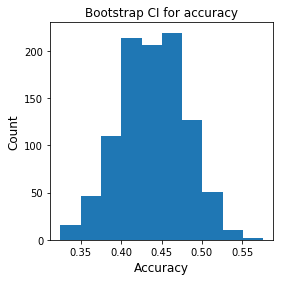

In [9]:
# Step 1: Model 
log_reg_estimator = LogisticRegression(random_state=10)

# Step 2: Identify Hyperparameters 
hyper_parameters = [{'multi_class': ['ovr'],
                     'C': [0.01, 0.1, 1, 10, 100, 1000]},
                    {'multi_class': ['multinomial'],
                     'C': [0.01, 0.1, 1, 10, 100, 1000],                
                     'solver': ['newton-cg']}]

# Step 3: Find Best Hyperparameters via CV GridSearch
best_params = CV_with_GridSearch(log_reg_estimator, 
                                 hyper_parameters, 
                                 cv=10)

# Step 4: Fit Model via Best Hyperparameters 
log_reg_classifier = LogisticRegression(random_state=10, 
                                        C=1000, 
                                        multi_class='ovr')

# Step 5: Evaluate model accuracy and confidence interval 
log_reg_classifier, validation_accuracy_log_reg, confidence_interval_log_reg = ( 
    estimate_model_results(log_reg_classifier, bootstrap_results=True) )

#### K-Nearest neighbors

C:\Users\natek\Anaconda3\envs\data-x\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{'n_neighbors': 24}

Grid scores on training set:

0.278 (+/-0.014) for {'n_neighbors': 1}
0.257 (+/-0.024) for {'n_neighbors': 2}
0.276 (+/-0.010) for {'n_neighbors': 3}
0.287 (+/-0.011) for {'n_neighbors': 4}
0.293 (+/-0.011) for {'n_neighbors': 5}
0.290 (+/-0.021) for {'n_neighbors': 6}
0.304 (+/-0.006) for {'n_neighbors': 7}
0.310 (+/-0.022) for {'n_neighbors': 8}
0.310 (+/-0.019) for {'n_neighbors': 9}
0.306 (+/-0.015) for {'n_neighbors': 10}
0.312 (+/-0.013) for {'n_neighbors': 11}
0.310 (+/-0.008) for {'n_neighbors': 12}
0.309 (+/-0.007) for {'n_neighbors': 13}
0.310 (+/-0.014) for {'n_neighbors': 14}
0.313 (+/-0.026) for {'n_neighbors': 15}
0.315 (+/-0.034) for {'n_neighbors': 16}
0.319 (+/-0.027) for {'n_neighbors': 17}
0.327 (+/-0.015) for {'n_neighbors': 18}
0.327 (+/-0.017) for {'n_neighbors': 19}
0.330 (+/-0.019) for {'n_neighbors': 20}
0.328 (+/-0.015) for {'n_neighbors': 21}
0.330 (+/-0.013) for {'n_neighbors': 22}
0.330 (+/

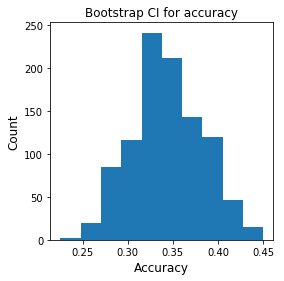

In [10]:
# Step 1: Model 
knn_estimator = KNeighborsClassifier()

# Step 2: Identify Hyperparameters 
hyper_parameters = [{'n_neighbors': range(1,50)}]

# Step 3: Find Best Hyperparameters via CV GridSearch
best_params = CV_with_GridSearch(knn_estimator, 
                                 hyper_parameters, 
                                 cv=10)

# Step 4: Fit Model via Best Hyperparameters 
knn_classifier = KNeighborsClassifier(n_neighbors=30)

# Step 5: Evaluate model accuracy and confidence interval 
knn_classifier, validation_accuracy_knn, confidence_interval_knn = ( 
    estimate_model_results(knn_classifier, bootstrap_results=True) )

#### Random Forest 

Best parameters set found on development set:

{'max_features': 9}

Grid scores on training set:

0.361 (+/-0.042) for {'max_features': 1}
0.360 (+/-0.027) for {'max_features': 2}
0.366 (+/-0.017) for {'max_features': 3}
0.365 (+/-0.006) for {'max_features': 4}
0.361 (+/-0.037) for {'max_features': 5}
0.363 (+/-0.016) for {'max_features': 6}
0.365 (+/-0.022) for {'max_features': 7}
0.368 (+/-0.020) for {'max_features': 8}
0.370 (+/-0.026) for {'max_features': 9}
Train labeling accuracy: 77.11 %
Val labeling accuracy: 41.06 %

Confusion matrix:
 [[12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  2  0  0  0  0  1  0  0  1  0  0]
 [ 0  0  0  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  8  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  2  0  1  2]
 [ 0  0  0  1  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0]
 [ 2  0  1  1  0  0  7  0  0  1  0  0  0  1  1  0  0  1  0  0]
 [ 0  0 

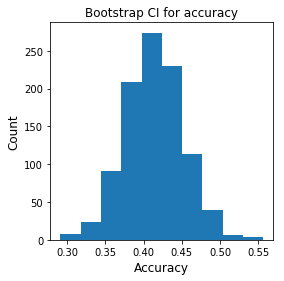

In [11]:
# Step 1: Model 
forest_estimator = RandomForestClassifier(n_estimators=100, 
                                          random_state=10)

# Step 2: Identify Hyperparameters 
num_features = range(1, len( features ))
hyper_parameters = [{'max_features': num_features}]

# Step 3: Find Best Hyperparameters via CV GridSearch 
best_params = CV_with_GridSearch(forest_estimator, 
                                 hyper_parameters, 
                                 cv=10)

# Step 4: Fit Model via Best Hyperparameters 
forest_classifier = RandomForestClassifier(n_estimators=500, 
                                           random_state=10, 
                                           max_features=6, 
                                           max_depth = 10)

# Step 5: Evaluate model accuracy and confidence interval 
forest_classifier, validation_accuracy_forest, confidence_interval_forest = ( 
    estimate_model_results(forest_classifier, bootstrap_results=True) )

#### Support Vector Machine

Note that the SVM classifier generally seems to favor larger classes in 'unbalanced' multicategorical training sets. Namely, our model ended up favoring the largest class in the image data set (i.e. gorilla category) by guessing 9 on all predictions, which is probably because there are way more images of Gorillas than any other category in the training data. As a result, we chose to use Logistic Regression that is not prone to this modelling issue. 

C:\Users\natek\Anaconda3\envs\data-x\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}

Grid scores on training set:

0.096 (+/-0.003) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.178 (+/-0.032) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.314 (+/-0.027) for {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
0.357 (+/-0.033) for {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
0.356 (+/-0.047) for {'C': 1, 'gamma': 0.2, 'kernel': 'rbf'}
0.345 (+/-0.053) for {'C': 1, 'gamma': 0.5, 'kernel': 'rbf'}
0.180 (+/-0.032) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.311 (+/-0.020) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.358 (+/-0.018) for {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
0.350 (+/-0.033) for {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
0.321 (+/-0.029) for {'C': 10, 'gamma': 0.2, 'kernel': 'rbf'}
0.301 (+/-0.029) for {'C': 10, 'gamma': 0.5, 'kernel': 'rbf'}
0.311 (+/-0.016) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.351 (+/-0.008) for {'C': 100, 'gamma': 0.001, 'kernel': 'rb

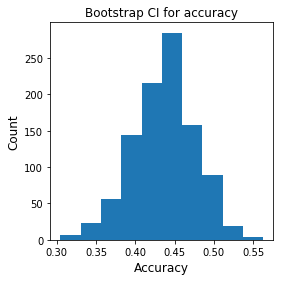

In [12]:
# Step 1: Model 
svm_estimator = SVC(decision_function_shape='ovr')

# Step 2: Identify Hyperparameters 
hyper_parameters = [{'kernel': ['rbf'],
                     'gamma': [1e-4, 1e-3, 0.01, 0.1, 0.2, 0.5],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 
                     'C': [1, 10, 100, 1000]}]

# Step 3: Find Best Hyperparameters via CV GridSearch 
best_params = CV_with_GridSearch(svm_estimator, 
                                 hyper_parameters, 
                                 cv=5)

# Step 4: Fit Model via Best Hyperparameters 
svm_classifier = SVC(decision_function_shape='ovr', 
                     C=1000, 
                     gamma=0.001, 
                     kernel='rbf') 

# Step 5: Evaluate model accuracy and confidence interval 
svm_classifier, validation_accuracy_svm, confidence_interval_svm = ( 
    estimate_model_results(svm_classifier, bootstrap_results=True) )

#### Model selection

In [13]:
classifier_results = pd.DataFrame(index=['Validation Accuracy', 
                                         '95% Confidence Interval'])
classifier_results['Logistic Regression'] = [validation_accuracy_log_reg, 
                                             confidence_interval_log_reg]
classifier_results['KNN'] = [validation_accuracy_knn, 
                             confidence_interval_knn]
classifier_results['Random Forest'] = [validation_accuracy_forest, 
                                       confidence_interval_forest]
classifier_results['SVM'] = [validation_accuracy_svm, 
                             confidence_interval_svm]

classifier_results

,Logistic Regression,KNN,Random Forest,SVM
Validation Accuracy,0.44,0.34,0.41,0.44
95% Confidence Interval,"[0.36, 0.52]","[0.27, 0.42]","[0.34, 0.49]","[0.35, 0.51]"


---
<h3>  Create CSV file of predictions for Test Data: </h3>

In [14]:
from datetime import datetime
def generate_submission(test, predictions, force=False):
    """
    This file generates a CSV file of predictions on the Test set
    and puts it in a 'submissions' folder in the current directory.
    
    Keyword arguments:
    test (pandas dataframe) -- test file
    predictions (pandas dataframe or ndarray) -- predictions on test set
    force (boolean) -- determines whether to generate submission
    
    Returns:
        None
    """
    if force:
        if not os.path.isdir("submissions"):
            os.mkdir("submissions")
        submission_df = pd.DataFrame({
            "id": test_df.index.values, 
            "animal class": predictions,
        },
            columns=['id', 'animal class'])
        timestamp = datetime.isoformat(datetime.now()).split(".")[0]
        timestamp = re.sub(r':', r'_', timestamp)
        submission_df.to_csv(Path(f'{os.getcwd()}/submissions/submission_{timestamp}.csv'), index=False)

        print(f'Created a CSV file: submission_{timestamp}.csv')
        print('You may now upload this CSV file for scoring.')

In [17]:
# Train final best model once on full training set before using it on unlabelled test set 
final_model = log_reg_classifier.fit(X_train, y_train) 
final_predictions = final_model.predict(X_test)
final_predictions = final_predictions.astype(int)

# # Change to true to generate prediction
generate_submission(test_df, final_predictions, True)

Created a CSV file: submission_2019-01-21T16_28_16.csv
You may now upload this CSV file for scoring.


C:\Users\natek\Anaconda3\envs\data-x\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
